# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot  as plt
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone


from time import time

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration and Visualization

### Portofolio dataset

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.shape

(10, 6)

###  Profile dataset

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.shape

(17000, 5)

In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
profile.describe(include = ['O'])

,gender,id
count,14825,17000
unique,3,17000
top,M,22588cd5f5e14859b153c7e9221085bd
freq,8484,1


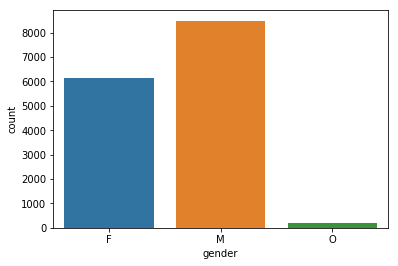

In [9]:
sns.countplot(profile['gender'])

In [10]:
def hist_plot(data, title, xlabel, ylabel):
    plt.hist(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

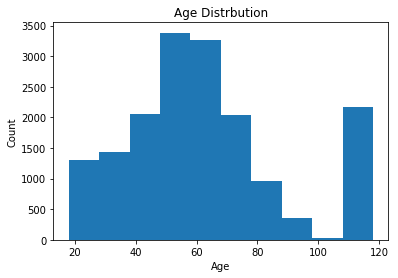

In [11]:
hist_plot(data=profile['age'], title='Age Distrbution', xlabel='Age', ylabel='Count')

As shown in the above graph, most customers are in the range of 40 to 70 years old with a lot of missing data which is recoreded as 118 years old in the dataset.

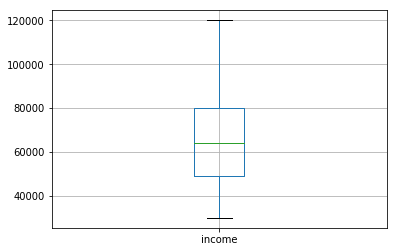

In [12]:
profile.boxplot('income')

In [13]:
profile[['gender','age']].groupby(['gender'], as_index = False).mean().sort_values(by='age',ascending=False)

,gender,age
0,F,57.544950
2,O,54.400943
1,M,52.116690


In [14]:
profile[['gender','income']].groupby(['gender'], as_index = False).mean().sort_values(by='income',ascending=False)

,gender,income
0,F,71306.412139
2,O,63287.735849
1,M,61194.601603


In [15]:
# Percent of customers with outlier income
above_mean_income = profile[profile['income']>80000].count().sum()/profile.shape[0]
below_mean_income = profile[profile['income']<49000].count().sum()/profile.shape[0]
print('Percent of customers with outlier income= {}%'.format(above_mean_income+below_mean_income))

Percent of customers with outlier income= 2.114411764705882%


In [16]:
missing_income = profile['income'].isnull().sum()
print("There is {} missing incomes, which represents {}% of the data".format(missing_income, missing_income/profile.shape[0]*100))

There is 2175 missing incomes, which represents 12.794117647058822% of the data


Conculsions: 
* Most income are between 40,000 and 70,000 with few missing values, and we have outliers in income.  
* Income outliers will be kept because as we continue the analysis it became apparent they represent 48% of the transaction.
* Mean age in female customers are older than customers with gender labeled as other then male customers.
* As in age, order of mean income is female, other, then male customers.

### Transcript dataset

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript.shape

(306534, 4)

In [19]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

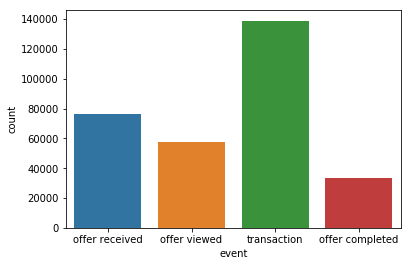

In [20]:
sns.countplot(transcript['event'])

In [21]:
transcript['value'].value_counts().head()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
Name: value, dtype: int64

In [22]:
transcript['value'].value_counts().tail()

{'amount': 439.14}    1
{'amount': 42.75}     1
{'amount': 650.75}    1
{'amount': 943.4}     1
{'amount': 44.21}     1
Name: value, dtype: int64

Conclusion:
* There are 4 event type in transcript: customer received an offer, customer view an offer, customer perform a transaction, and customer complete an offer.
* Each offer has an offer id, offer amount, and offer reward.

# Data preparation

### portfolio dataset   
* One-hot encode channels and offer type then concat with dataset.
* Drop original columns after encoding.
* Rename columns into meaningful names.

In [23]:
def clean_portfolio(portfolio):
    
    # one-hot encode channels column
    channels = ['web', 'email', 'mobile', 'social']

    for channel in channels:
        portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1
        
    # one-hot encode offer_type
    dummies = pd.get_dummies(portfolio['offer_type'], prefix='event_type', prefix_sep='_')

    # Concatenate with the original dataframe
    portfolio = pd.concat([portfolio, dummies], axis=1)
    
    # Drop original columns
    portfolio.drop(['channels', 'offer_type'],axis=1 ,inplace=True)
    
    # rename column names into meaningful names
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
    portfolio.rename(columns={'duration': 'offer_duration_days'}, inplace=True)
    portfolio.rename(columns={'difficulty': 'offer_difficulty'}, inplace=True)
    portfolio.rename(columns={'reward': 'offer_reward'}, inplace=True)
    for col in ["email", "mobile", "social", "web"]:
        portfolio.rename(columns={col: ("channel_" + col)}, inplace=True)

    
    return portfolio

In [24]:
portfolio_clean = clean_portfolio(portfolio.copy())

In [25]:
portfolio_clean.head()

,offer_difficulty,offer_duration_days,offer_id,offer_reward,channel_web,channel_email,channel_mobile,channel_social,event_type_bogo,event_type_discount,event_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


### Profile dataset
* Convert became_member_on date column from int to date time type.
* Date of a customer became member is encoded as follow: 
 1. One-hot encode year.
 2. Drop days since its distribution is uniform.
 3. Month encoded as quarter of the year because a lot of customers became member on the first or last months of the year.
* Drop 2175 null rows, since they have no information about customers except the date of becoming members.
* One-hot encode gender column and drop the original column.
* Rename column names into meaningful names

In [26]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

#### Investigate null values

In [27]:
profile['gender'].isnull().sum()

2175

In [28]:
len(profile[profile['age'] == 118])

2175

In [29]:
profile['income'].isnull().sum()

2175

In [30]:
profile[(profile['age'] == 118)].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


Data that have rows with missing values have all columns missing except the date of becomming member and the id, so these rows will be dropped since it gives no value.

In [31]:
def clean_profile(profile):
    
    # Convert became_member_on date from int to date time type
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    profile['year'] = profile['became_member_on'].dt.year
    profile['quarter'] = profile['became_member_on'].dt.quarter
   
    
    # Drop null values since these customer does not provide any information about them
    profile.drop(profile[profile.age==118].index, inplace=True)
    
    # One-hot encode gender
    gender_dummies = pd.get_dummies(profile.gender, prefix='gender', prefix_sep='_')
    profile = pd.concat([profile, gender_dummies], axis=1)
    
    # One-hot encode date
    year_dummy = pd.get_dummies(profile.year, prefix='year', prefix_sep='_')
    quarter_dummy = pd.get_dummies(profile.quarter, prefix='quarter', prefix_sep='_')
    profile = pd.concat([profile, year_dummy, quarter_dummy], axis=1)
    
    # Drop original column
    profile.drop(['gender', 'became_member_on', 'year', 'quarter'], axis=1, inplace=True)
    
    # rename column name into meaningful name
    profile.rename(columns={'id': 'customer_id'}, inplace=True)

    
    return profile

In [32]:
profile_clean = clean_profile(profile.copy())

In [33]:
profile_clean['income'].isnull().sum()

0

In [34]:
profile_clean.head()

,age,customer_id,income,gender_F,gender_M,gender_O,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,quarter_1,quarter_2,quarter_3,quarter_4
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,1,0,0,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,1,0,1,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,1,1,0,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,1,0,0,0,0,1


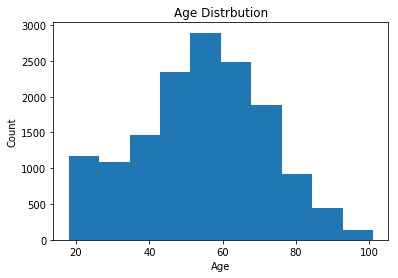

In [35]:
hist_plot(data=profile_clean['age'], title='Age Distrbution', xlabel='Age', ylabel='Count')

[Text(0.5, 1.0, 'income in general')]

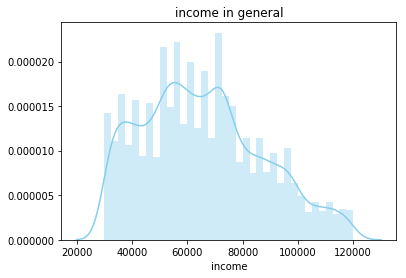

In [36]:
sns.distplot(profile_clean["income"] , color="skyblue").set(title = 'income in general')

<Figure size 432x288 with 0 Axes>

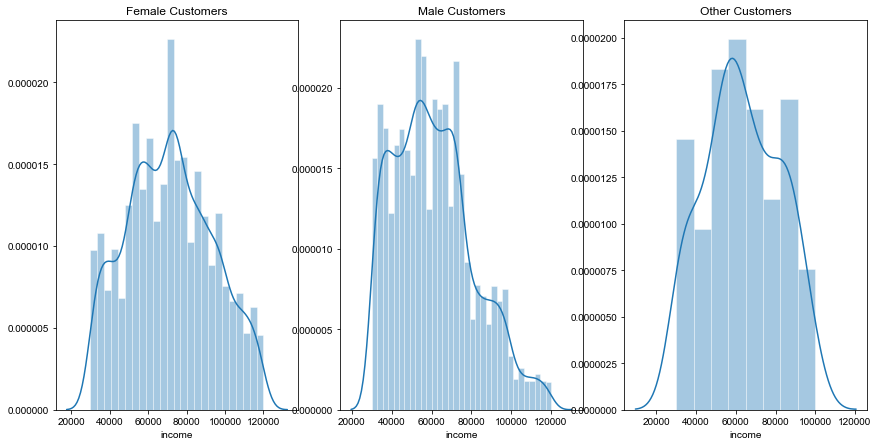

In [37]:
male_customers = profile_clean[profile_clean['gender_M'] == 1]
female_customers = profile_clean[profile_clean['gender_F'] == 1]
other_customers = profile_clean[profile_clean['gender_O'] == 1]

plt.figure()
fig, ax = plt.subplots(1,3, figsize=(12, 6))
fig.tight_layout()
sns.set(style="darkgrid")
sns.FacetGrid
sns.distplot(female_customers['income'], ax=ax[0]).set(title = 'Female Customers')
sns.distplot(male_customers['income'], ax=ax[1]).set(title = 'Male Customers')
sns.distplot(other_customers['income'], ax=ax[2]).set(title = 'Other Customers')
plt.show()

Conclusions:
* Majorities of customers are between 40 and 75 years old.
* Income in general are mostly between 50,000 and 75,000
* Male customers income distribution are skewed to the right while female and other customers income distribution are approximately normally curved.

### Transcript dataset
* One-hot encode event column.
* Encode value column and split it to different columns.
* Merge offer id and offer_id columns.
* Remove customer ids that are not available in profile dataset.
* Assign the value zero to offer amount and reward with null values.
* Change time column from hours to days.
* Change column names into a meaningful names.
* Drop original columns that were encoded.

In [38]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There is no null values.

In [39]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [40]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [41]:
def clean_transcript(transcript):
    
    # One-hot encode events 
    dummies = pd.get_dummies(transcript.event)
    transcript = pd.concat([transcript, dummies], axis=1)
    
    # Encode value column and split it to differet columns
    value_df = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)
    transcript = pd.concat([transcript, value_df], axis=1)
    
    # Assign values of offer id column to offer_id column to remove duplicate columns
    transcript['offer_id'] = transcript['offer_id'].fillna(transcript['offer id'])
    
    # offer amount and reward with null values will be assigned as zeros
    transcript['amount'] = transcript['amount'].replace(np.nan, 0)
    transcript['reward'] = transcript['reward'].replace(np.nan, 0)
    
    # Change time column from hours to days
    transcript['time'] = transcript['time']/24.0
    
    # Change column name into a meaningful name
    transcript.rename(columns= {"time": "time_days"}, inplace = True)
    transcript.rename(columns= {'amount': 'money_spent'}, inplace=True)
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    transcript.rename(columns={'reward': 'reward_gained'}, inplace=True)
    transcript.rename(columns={'transaction': 'transaction_done'}, inplace=True)
    
    # Drop customers ids that not available at profile dataset, because we know nothing about them.
    transcript = transcript[transcript['customer_id'].isin(profile_clean['customer_id'])]

    # Drop original columns 
    transcript.drop(['event', 'value', 'offer id'], axis=1, inplace=True)
        
    return transcript

In [42]:
transcript_clean = clean_transcript(transcript.copy())

In [43]:
transcript_clean.isnull().sum()/transcript_clean.shape[0]

customer_id         0.000000
time_days           0.000000
offer completed     0.000000
offer received      0.000000
offer viewed        0.000000
transaction_done    0.000000
money_spent         0.000000
offer_id            0.454451
reward_gained       0.000000
dtype: float64

In [44]:
transcript_clean[pd.isna(transcript_clean['offer_id'])].head()

,customer_id,time_days,offer completed,offer received,offer viewed,transaction_done,money_spent,offer_id,reward_gained
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0,0,0,1,0.83,NaN,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,0,0,0,1,34.56,NaN,0.0
12659,54890f68699049c2a04d415abc25e717,0.0,0,0,0,1,13.23,NaN,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,0,0,0,1,19.51,NaN,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,0,0,0,1,18.97,NaN,0.0


*Null values in offer_id means that it is transaction.*

In [45]:
transcript_clean.head()

,customer_id,time_days,offer completed,offer received,offer viewed,transaction_done,money_spent,offer_id,reward_gained
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
2,e2127556f4f64592b11af22de27a7932,0.0,0,1,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0
5,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0,0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0,0,0.0,3f207df678b143eea3cee63160fa8bed,0.0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0


In [46]:
portfolio_clean.head()

,offer_difficulty,offer_duration_days,offer_id,offer_reward,channel_web,channel_email,channel_mobile,channel_social,event_type_bogo,event_type_discount,event_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [47]:
profile_clean.head()

,age,customer_id,income,gender_F,gender_M,gender_O,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,quarter_1,quarter_2,quarter_3,quarter_4
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,1,0,0,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,1,0,1,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,1,1,0,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [48]:
transcript_clean.offer_id.value_counts()

fafdcd668e3743c1bb461111dcafc2a4    18062
2298d6c36e964ae4a3e7e9706d1fb8c2    17920
f19421c1d4aa40978ebb69ca19b0e20d    16989
ae264e3637204a6fb9bb56bc8210ddfd    16241
4d5c57ea9a6940dd891ad53e9dbe8da0    16232
9b98b8c7a33c4b65b9aebfe6a799e6d9    14372
2906b810c7d4411798c6938adc9daaa5    14002
5a8bc65990b245e5a138643cd4eb9837    12516
0b1e1539f2cc45b7b9fa7c272da2e1d7    12327
3f207df678b143eea3cee63160fa8bed    10144
Name: offer_id, dtype: int64

In [49]:
# All events related to a specific customer
transcript_clean[transcript_clean.customer_id == '78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,time_days,offer completed,offer received,offer viewed,transaction_done,money_spent,offer_id,reward_gained
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,0,1,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
15561,78afa995795e4d85b5d9ceeca43f5fef,0.25,0,0,1,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
47582,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,0,0,1,19.89,NaN,0.0
47583,78afa995795e4d85b5d9ceeca43f5fef,5.50,1,0,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,6.00,0,0,0,1,17.78,NaN,0.0
53176,78afa995795e4d85b5d9ceeca43f5fef,7.00,0,1,0,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0
85291,78afa995795e4d85b5d9ceeca43f5fef,9.00,0,0,1,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0
87134,78afa995795e4d85b5d9ceeca43f5fef,9.25,0,0,0,1,19.67,NaN,0.0
92104,78afa995795e4d85b5d9ceeca43f5fef,10.00,0,0,0,1,29.72,NaN,0.0
141566,78afa995795e4d85b5d9ceeca43f5fef,15.75,0,0,0,1,23.93,NaN,0.0


**It looks like every interaction the user do is represented in a seperate column, e.g. offer received, offer viewed, offer completed and transactions all are stored seperately. We need to follow each customer and offers they received and their interaction with offers' events.**

To solve the problem in the offer dataset we will follow the next steps:

1. Retreive customers id list.
2. For each customer:
 1. Retrieve information related to the customer.
 2. Retrieve offers id list.
 3. Drop null and duplicate ids.
 4. For each offer the customer has got: 
     1. Retrieve customer information related with the offer.
     2. Retrieve time when the customer completed the offer 
     3. Retrieve event's info: offer received, offer viewed, and offer completed.
     4. Retrieve transaction and money spent on the offer and reward related to the offer if available.
     5. If the offer has been received, viewed and completed then assign a True value to the offer_successful column.
     6. Append the values we have got to the transaction data frame.
3. Merge customers dataset with transactions data set.
4. Merge offers dataset with customers dataset.

In [125]:
def merge_transaction(transcript):
    customer_ids_list = list(transcript_clean.customer_id.unique())
    transactions_df = pd.DataFrame(columns= ['customer_id', 'offer_id', 'time_days', 'offer_received', 'offer_viewed',
                                         'offer_completed', 'offer_successful', 'transaction_done', 'money_spent', 'reward_gained'])
    customer_df = pd.DataFrame()
    past_time = 0
    for customer_id in customer_ids_list:
    
        customer_df = transcript_clean[transcript_clean.customer_id == customer_id]
        offers_id_list = customer_df['offer_id']
        offers_id_list = offers_id_list.drop_duplicates()
        offers_id_list = [x for x in offers_id_list if pd.notnull(x)]

        for offer_id in offers_id_list:
        
            customer_df_1 = customer_df[(customer_df['customer_id'] == customer_id) & (customer_df['offer_id']== offer_id)]
            
            cur_time_days = customer_df_1.loc[:,'time_days'].max()
            offer_completed = customer_df_1.loc[:,'offer completed'].max()
            offer_received = customer_df_1.loc[:,'offer received'].max()
            offer_viewed = customer_df_1.loc[:,'offer viewed'].max()
            reward_gained = customer_df_1.loc[:,'reward_gained'].sum()
        
            customer_transaction_df = customer_df[customer_df['customer_id'] == customer_id]
            cur_time_transaction = customer_transaction_df[(customer_transaction_df['time_days']> past_time) & (customer_transaction_df['time_days']<= cur_time_days)]
            money_spent = cur_time_transaction.loc[:,'money_spent'].sum()
            if (money_spent):
                transaction_done=1
            else:
                transaction_done=0
      
            past_time = cur_time_days
        
            if (offer_received and offer_viewed and offer_completed): 
                offer_successful = 1
            else:
                offer_successful = 0
            
            if (cur_time_days >= 0):
                transactions_df = transactions_df.append({'customer_id': customer_id, 'offer_id': offer_id, 'time_days': cur_time_days,
                                                'offer_received': offer_received, 'offer_viewed': offer_viewed, 'offer_completed': offer_completed,
                                                'offer_successful': offer_successful,'transaction_done':transaction_done, 'money_spent':money_spent,
                                                'reward_gained': reward_gained}, ignore_index=True)
                
                
    transactions_df.to_csv('transactions.csv')
    

In [63]:
merge_transaction(transcript_clean)

In [64]:
transactions_df = pd.read_csv('transactions.csv')
transactions_df.drop(['Unnamed: 0', 'time_days'], axis=1, inplace=True) 

In [65]:
transactions_df.head()

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,offer_successful,transaction_done,money_spent,reward_gained
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,1,19.89,5.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,1,17.78,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,1,95.04,10.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,26.56,5.0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,0,0.00,0.0


In [66]:
transactions_df[transactions_df['customer_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,offer_successful,transaction_done,money_spent,reward_gained
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,1,19.89,5.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,1,17.78,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,1,95.04,10.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,26.56,5.0


In [67]:
customers_df = transactions_df.merge(profile_clean, on='customer_id')
customers_df.head()

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,offer_successful,transaction_done,money_spent,reward_gained,age,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,quarter_1,quarter_2,quarter_3,quarter_4
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,1,19.89,5.0,75,...,0,0,0,0,1,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,1,17.78,0.0,75,...,0,0,0,0,1,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,1,95.04,10.0,75,...,0,0,0,0,1,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,26.56,5.0,75,...,0,0,0,0,1,0,0,1,0,0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,0,0.00,0.0,68,...,0,0,0,0,0,1,0,1,0,0


In [68]:
customers_df[(customers_df['income']>80000) & (customers_df['transaction_done'] == 1)].shape[0]/customers_df[customers_df['transaction_done'] == 1].shape[0]

0.23401042602912098

In [69]:
customers_df[(customers_df['income']<49000) & (customers_df['transaction_done'] == 1)].shape[0]/customers_df[customers_df['transaction_done'] == 1].shape[0]

0.24943375876325724

*As explained before nearly half of number of transaction comes from people with outliers income.*

In [70]:
# Merge data 
data_df = customers_df.merge(portfolio_clean, on='offer_id')
data_df.head()

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,offer_successful,transaction_done,money_spent,reward_gained,age,...,offer_difficulty,offer_duration_days,offer_reward,channel_web,channel_email,channel_mobile,channel_social,event_type_bogo,event_type_discount,event_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,1,19.89,5.0,75,...,5,7,5,1,1,1,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,1,18.42,5.0,68,...,5,7,5,1,1,1,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,0,0.00,5.0,65,...,5,7,5,1,1,1,0,1,0,0
3,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0,0,0.00,0.0,56,...,5,7,5,1,1,1,0,1,0,0
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0,0,0.00,0.0,59,...,5,7,5,1,1,1,0,1,0,0


 To prepare data for modeling we need to drop some columns: 
 * Drop one column of one-hot encoded columns that could cause multicollinearity.
 * Drop unneeded columns, e.g. offer_received, offer_viewed, and offer_completed and keep offer_successful column. 
 * Drop reward_gaind since it equals to the reward related to the offer.

In [71]:
data_df.columns.tolist()

['customer_id',
 'offer_id',
 'offer_received',
 'offer_viewed',
 'offer_completed',
 'offer_successful',
 'transaction_done',
 'money_spent',
 'reward_gained',
 'age',
 'income',
 'gender_F',
 'gender_M',
 'gender_O',
 'year_2013',
 'year_2014',
 'year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
 'quarter_1',
 'quarter_2',
 'quarter_3',
 'quarter_4',
 'offer_difficulty',
 'offer_duration_days',
 'offer_reward',
 'channel_web',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'event_type_bogo',
 'event_type_discount',
 'event_type_informational']

In [111]:
col_to_drop = ['offer_received', 'offer_viewed', 'offer_completed', 'transaction_done', 'gender_F', 'year_2013', 'quarter_1', 
              'event_type_bogo', 'reward_gained']
data_clean = data_df.drop(columns=col_to_drop, axis=1)

In [112]:
data_clean.head()

,customer_id,offer_id,offer_successful,money_spent,age,income,gender_M,gender_O,year_2014,year_2015,...,quarter_4,offer_difficulty,offer_duration_days,offer_reward,channel_web,channel_email,channel_mobile,channel_social,event_type_discount,event_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,19.89,75,100000.0,0,0,0,0,...,0,5,7,5,1,1,1,0,0,0
1,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,18.42,68,70000.0,1,0,0,0,...,0,5,7,5,1,1,1,0,0,0
2,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0.00,65,53000.0,1,0,0,0,...,0,5,7,5,1,1,1,0,0,0
3,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.00,56,88000.0,0,0,0,0,...,0,5,7,5,1,1,1,0,0,0
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.00,59,41000.0,1,0,0,1,...,0,5,7,5,1,1,1,0,0,0


# Data Modeling

In [113]:
from sklearn.model_selection import train_test_split

X = data_clean.drop(['offer_successful', 'customer_id', 'offer_id'], axis=1)
y = data_clean['offer_successful']

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 44177 samples.
Testing set has 11045 samples.


In [114]:
target_names=['Offer failed', 'Offer successful']

In [115]:
from sklearn.metrics import accuracy_score, f1_score

lg_reg = LogisticRegression(random_state=42)
lg_reg.fit(X_train, y_train)
lg_pred = lg_reg.predict(X_test)

print('LogisticRegression Model')
print(classification_report(y_test, lg_pred, target_names=target_names))

C:\Users\rawan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression Model
                  precision    recall  f1-score   support

    Offer failed       0.80      0.80      0.80      6392
Offer successful       0.72      0.72      0.72      4653

       micro avg       0.77      0.77      0.77     11045
       macro avg       0.76      0.76      0.76     11045
    weighted avg       0.77      0.77      0.77     11045



In [116]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print('RandomForestClassifier Model')
print(classification_report(y_test, rf_pred, target_names=target_names))

RandomForestClassifier Model
                  precision    recall  f1-score   support

    Offer failed       0.82      0.81      0.82      6392
Offer successful       0.75      0.76      0.75      4653

       micro avg       0.79      0.79      0.79     11045
       macro avg       0.79      0.79      0.79     11045
    weighted avg       0.79      0.79      0.79     11045



In [117]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = KNeighborsClassifier()
neighbors.fit(X_train, y_train)
neighbors_pred = neighbors.predict(X_test)

print('KNeighborsClassifier Model')
print(classification_report(y_test, neighbors_pred, target_names=target_names))

KNeighborsClassifier Model
                  precision    recall  f1-score   support

    Offer failed       0.77      0.72      0.75      6392
Offer successful       0.65      0.70      0.68      4653

       micro avg       0.72      0.72      0.72     11045
       macro avg       0.71      0.71      0.71     11045
    weighted avg       0.72      0.72      0.72     11045



## Model Evaluation and Results

In the modeling step I have built 3 models printed their classification report:
* Logistic regression: 
    1. Precision: 0.77
    2. Recall: 0.77
    3. F1 score: 0.77
* Random forest classifier:
     1. Precision: 0.79
     2. Recall: 0.79
     3. F1 score: 0.79
* KNeighbors classifier 
     1. Precision:  0.72
     2. Recall: 0.72
     3. F1 score: 0.72   
     
Based on the overall score random forest classifier is the best model.

### Tuning the best model:


In [118]:
# Get model parameters
print(rf.get_params())

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [119]:

n_estimators = [100, 200]
max_features = ['auto', 'sqrt']
max_depth = [10, 50, 100]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_2 = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.0min finished


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [120]:
rf = RandomForestClassifier(n_estimators= 200,
 min_samples_split= 10,
 min_samples_leaf= 1,
 max_features = 'auto',
 max_depth = 10,
 bootstrap = True)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print('RandomForestClassifier Model')
print(classification_report(y_test, rf_pred, target_names=target_names))

RandomForestClassifier Model
                  precision    recall  f1-score   support

    Offer failed       0.84      0.83      0.83      6392
Offer successful       0.77      0.78      0.77      4653

       micro avg       0.81      0.81      0.81     11045
       macro avg       0.80      0.80      0.80     11045
    weighted avg       0.81      0.81      0.81     11045



## Feature Importance 

In [121]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  


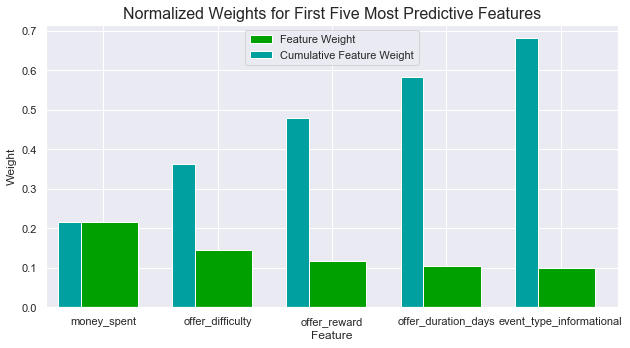

In [122]:
importances = rf.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

Five most features for offer success prediction are:
1. Money the customer spent to get the offer.
2. Offer difficulty (amount required to be spent to get an offer).
3. The amount of reward for the offer.
4. Duration of offer.
5. Event type.


In [124]:

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(rf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, rf_pred)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, rf_pred)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, reduced_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.8077
F-score on testing data: 0.7725

Final Model trained on reduced data
------
Accuracy on testing data: 0.7758
F-score on testing data: 0.7363


**The model has higher accuracy score and f1_score on full data.**